# Testing Potential Models

## Creating Facial Detection Function facial_detection(impath, margin)

In [3]:
from mtcnn import MTCNN



1/1 [==============================] - 0s 109ms/step


[{'box': [96, 46, 261, 358],
  'confidence': 0.9999721050262451,
  'keypoints': {'left_eye': (169, 194),
   'right_eye': (292, 189),
   'nose': (234, 275),
   'mouth_left': (189, 332),
   'mouth_right': (280, 328)}}]

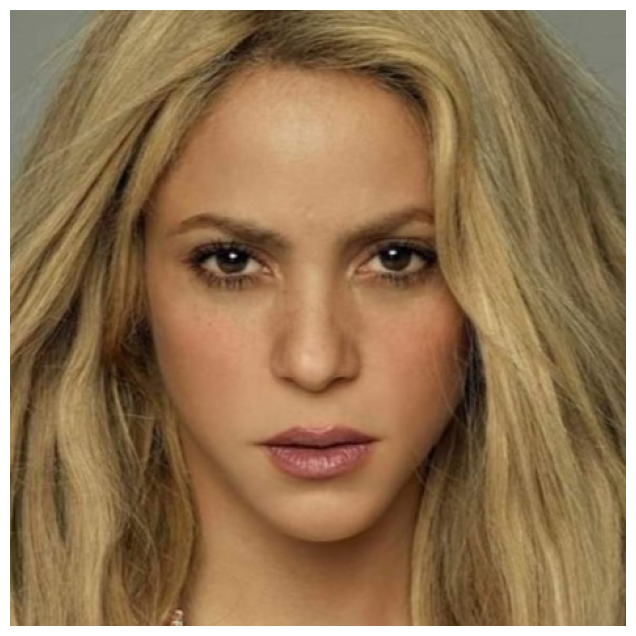

In [4]:
import matplotlib.pyplot as plt

filename = "data/my_images/shakira.jpg"
pixels = plt.imread(filename)

# Create face detector
detector = MTCNN()

plt.figure(figsize=(12, 8))
plt.imshow(pixels)
plt.axis('off')

# Detect face
face = detector.detect_faces(pixels)
face

In [8]:
import PIL

def facial_detection(impath, margin):
    pixels = plt.imread(impath)
    img = PIL.Image.open(impath)
    
    detector = MTCNN()
    face = detector.detect_faces(pixels)

    box = face[0]["box"]

    # Original Face Shape
    x = max(box[0] - margin, 0)
    y = max(box[1] - margin, 0)
    width = min(box[2] + 2 * margin, img.width - x)
    height = min(box[3] + 2 * margin, img.height - y)

    center = (x + (width / 2), y + (height / 2))

    # Square Face Shape
    x = center[0] - (height / 2)
    y = center[1] - (height / 2)
    right = x + height
    bottom = y + height

    cropped_img = img.crop((x, y, right, bottom))
    return cropped_img

1/1 [==============================] - 0s 119ms/step


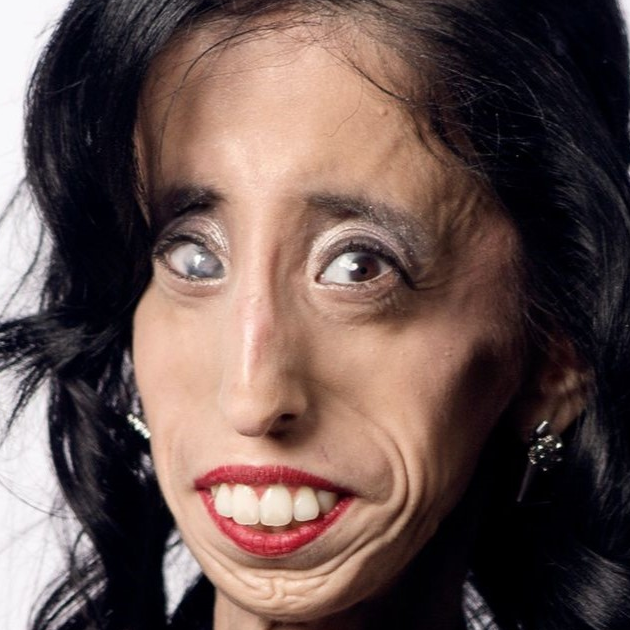

In [9]:
impath = "data/my_images/ugly_girl.jpg"
margin = 10

facial_detection(impath, margin)

## Creating Stratified Regression Data

In [12]:
import numpy as np
import pathlib
import tensorflow as tf

img_height = 224
img_width = 224

def image_to_tensor(img):
    img = img.resize((img_width, img_height))
    img = np.array(img)
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    return tensor

def extract_ratings(text_path):
    with open(text_path) as ratings:
        ratings = ratings.readlines()[0]
        ratings = np.array(ratings.split())
        ratings = ratings.astype(float)

    return ratings

m_train_txt = "data/gender_split_regression/m_train_ratings"
f_train_txt = "data/gender_split_regression/f_train_ratings"

m_test_txt = "data/gender_split_regression/m_test_ratings"
f_test_txt = "data/gender_split_regression/f_test_ratings"

m_train_ratings = extract_ratings(m_train_txt)
f_train_ratings = extract_ratings(f_train_txt)

m_test_ratings = extract_ratings(m_test_txt)
f_test_ratings = extract_ratings(f_test_txt)

m_train_dir = pathlib.Path("data/gender_split_regression/m_train")
f_train_dir = pathlib.Path("data/gender_split_regression/f_train")
m_test_dir = pathlib.Path("data/gender_split_regression/m_test")
f_test_dir = pathlib.Path("data/gender_split_regression/f_test")

m_train_images = list(m_train_dir.glob("*.jpg"))
f_train_images = list(f_train_dir.glob("*.jpg"))
m_test_images = list(m_test_dir.glob("*.jpg"))
f_test_images = list(f_test_dir.glob("*.jpg"))

# Implementing facial_detection()
m_x_train = np.array([image_to_tensor(facial_detection(impath, 10)) for impath in m_train_images])
m_y_train = m_train_ratings

f_x_train = np.array([image_to_tensor(facial_detection(impath, 10)) for impath in f_train_images])
f_y_train = f_train_ratings

m_x_test = np.array([image_to_tensor(facial_detection(impath, 10)) for impath in m_test_images])
m_y_test = m_test_ratings

f_x_test = np.array([image_to_tensor(facial_detection(impath, 10)) for impath in f_test_images])
f_y_test = f_test_ratings

1/1 [==============================] - 0s 357ms/step


## Resnet Male Model With Face Detection

In [21]:
m_base_model = tf.keras.applications.ResNet152(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
m_base_model.trainable = False

m_model = tf.keras.Sequential([
    m_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="linear")
])

m_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["MeanAbsoluteError"])

In [22]:
m_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_77015 (Dense)         (None, 1)                 2049      
                                                                 
Total params: 58372993 (222.68 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [ ]:
m_history = m_model.fit(m_x_train, m_y_train, batch_size=32, epochs=50, validation_data=(m_x_test, m_y_test))

Epoch 1/50
51/51 [==============================] - 403s 8s/step - loss: 1.1872 - mean_absolute_error: 0.8232 - val_loss: 0.4365 - val_mean_absolute_error: 0.4846
Epoch 2/50
51/51 [==============================] - 385s 8s/step - loss: 0.4213 - mean_absolute_error: 0.5097 - val_loss: 0.3969 - val_mean_absolute_error: 0.4803
Epoch 3/50
51/51 [==============================] - 385s 8s/step - loss: 0.4092 - mean_absolute_error: 0.5070 - val_loss: 0.3819 - val_mean_absolute_error: 0.4882
Epoch 4/50
51/51 [==============================] - 385s 8s/step - loss: 0.4026 - mean_absolute_error: 0.5035 - val_loss: 0.3764 - val_mean_absolute_error: 0.4769
Epoch 5/50
51/51 [==============================] - 385s 8s/step - loss: 0.3955 - mean_absolute_error: 0.4954 - val_loss: 0.3684 - val_mean_absolute_error: 0.4743
Epoch 6/50
51/51 [==============================] - 383s 8s/step - loss: 0.3879 - mean_absolute_error: 0.4936 - val_loss: 0.3636 - val_mean_absolute_error: 0.4682
Epoch 7/50
51/51 [====

In [ ]:
def plot_reg_history(history):
    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
plot_reg_history(m_history)